# Setup

In [1]:
# General libraries
import pandas as pd
import numpy as np

# Utilities
from pathlib import Path
import psutil
import gc
import os

# Cuda
import torch

In [2]:
# Warnings
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Suppress the specific PerformanceWarning
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Pd options
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

In [3]:
# Get the number of available CPUs
num_cpus = os.cpu_count()

# Show
print(num_cpus)

8


In [4]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
else:
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


# Directory

In [5]:
# Set the right directory
current_path = Path.cwd()
if current_path.name in ['notebooks', 'src']:
    os.chdir('..')
    print(f"Moved up from {current_path.name} to: {os.getcwd()}")
else:
    print(f"Already in project directory: {os.getcwd()}")

Moved up from notebooks to: /Users/ignasipascual/Documents/GitHub/Forecaster


# Assets

## Import assets

In [6]:
# Import assets
from utils.data_preparation import DataPreparation
from utils.feature_engineering import FeatureEngineering
from utils.create_baselines import CreateBaselines
from utils.forecaster import Forecaster
from utils.evaluator import Evaluator
from utils.auxiliar import *

# Load data

In [7]:
# Raw URL of the CSV file
url = 'https://raw.githubusercontent.com/jordisc97/Kaggle_HackUPC/main/train_v_2_kaggle_23.csv'

# Load the CSV into a DataFrame
df_input = pd.read_csv(url)

# Show
df_input.head()

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units
0,202224-2961,2022-06-18,202224,2961,15,Doraemon,186631,15.6,Gaming,52.0,88.0
1,202225-2961,2022-06-25,202225,2961,15,Doraemon,186631,15.6,Gaming,6.0,88.0
2,202226-2961,2022-07-02,202226,2961,15,Doraemon,186631,15.6,Gaming,60.0,138.0
3,202227-2961,2022-07-09,202227,2961,15,Doraemon,186631,15.6,Gaming,158.0,65.0
4,202228-2961,2022-07-16,202228,2961,15,Doraemon,186631,15.6,Gaming,23.0,30.0


## Formatting

In [8]:
# Convert all column names to lowercase
df_input.columns = df_input.columns.str.lower()

# Date format
df_input['date'] = pd.to_datetime(df_input['date'])

# Convert each specified column to string
character_cols = ['reporterhq_id', 'product_number', 'prod_category', 'specs', 'display_size', 'segment']
for col in character_cols:
    df_input[col] = df_input[col].astype(str)

# Convert signal columns to numeric, coercing errors to NaN
signal_cols = ['sales_units', 'inventory_units']
for col in signal_cols:
    df_input[col] = pd.to_numeric(df_input[col], errors='coerce')

# Select the specified columns
df_input = df_input[['reporterhq_id', 'product_number', 'prod_category', 'specs', 'display_size', 'segment', 'date', 'sales_units', 'inventory_units']]

# Sort by 'id_column' and 'date' in ascending order
df_input = df_input.sort_values(by=['reporterhq_id', 'product_number', 'date'])

# Show
df_input.head()

,reporterhq_id,product_number,prod_category,specs,display_size,segment,date,sales_units,inventory_units
913,12,10857,Doraemon,108304,15.6,Gaming,2021-01-30,0.0,52.0
914,12,10857,Doraemon,108304,15.6,Gaming,2021-02-06,8.0,48.0
915,12,10857,Doraemon,108304,15.6,Gaming,2021-02-13,39.0,72.0
916,12,10857,Doraemon,108304,15.6,Gaming,2021-02-20,0.0,138.0
917,12,10857,Doraemon,108304,15.6,Gaming,2021-02-27,69.0,87.0


## Statistics

In [9]:
# Print the number of rows and columns
print(f"Number of columns in df_input: {df_input.shape[1]}")
print(f"Number of rows in df_input: {df_input.shape[0]}")

# Print the number of distinct values for each specified column
print(f"Number of distinct reporterhq_id: {df_input['reporterhq_id'].nunique()}")
print(f"Number of distinct product_number: {df_input['product_number'].nunique()}")

Number of columns in df_input: 9
Number of rows in df_input: 25139
Number of distinct reporterhq_id: 20
Number of distinct product_number: 233


In [10]:
# Calculate the percentage of NA values in the entire DataFrame
total_rows = len(df_input)
total_na = df_input.isna().sum().sum()
percent_na_total = (total_na / (total_rows * df_input.shape[1])) * 100
print(f"Percentage of NA values: {percent_na_total:.2f}%")

Percentage of NA values: 0.44%


# Data Preparation

In [11]:
# Init class
data_preparation = DataPreparation()

In [12]:
# Run data preparation
df_data_prepared = data_preparation.run_data_preparation(
    df=df_input,
    group_cols=['reporterhq_id', 'product_number'],
    date_col='date',
    target='inventory_product_units',
    horizon=13,
    complete_dataframe=False,
    smoothing=True,
    dp_window_size=13,
    n_cutoffs=5
)

# Show
df_data_prepared.head()

Starting data preparation...
Auto-detected frequency: W-SAT
Identified signal columns: ['sales_units', 'inventory_units']
Applied smoothing with a moving average window size of 13.
Identified cutoff dates for backtesting: [Timestamp('2023-05-06 00:00:00'), Timestamp('2023-04-01 00:00:00'), Timestamp('2023-03-04 00:00:00'), Timestamp('2023-02-04 00:00:00'), Timestamp('2023-01-07 00:00:00')]
Created backtesting DataFrame.
Added forecasting horizon for the last cutoff.
Data preparation completed.


,reporterhq_id,product_number,prod_category,specs,display_size,segment,date,sales_units,inventory_units,filled_sales_units,filled_inventory_units,cutoff,sample
3,12,10857,Doraemon,108304,15.6,Gaming,2021-01-30,0.0,52.0,0.0,52.0,2023-01-07,train
7,12,10857,Doraemon,108304,15.6,Gaming,2021-02-06,8.0,48.0,8.0,48.0,2023-01-07,train
11,12,10857,Doraemon,108304,15.6,Gaming,2021-02-13,39.0,72.0,39.0,72.0,2023-01-07,train
15,12,10857,Doraemon,108304,15.6,Gaming,2021-02-20,0.0,138.0,0.0,138.0,2023-01-07,train
19,12,10857,Doraemon,108304,15.6,Gaming,2021-02-27,69.0,87.0,69.0,87.0,2023-01-07,train


# Feature Engineering

In [13]:
# Init class
feature_engineering = FeatureEngineering()

In [14]:
# Run feature engineering
df_with_features = feature_engineering.run_feature_engineering(
    df=df_data_prepared,
    group_cols=['reporterhq_id', 'product_number', 'cutoff'],
    date_col='date',
    target='filled_inventory_units',
    freq='W',
    fe_window_size=(4, 13),
    lags=(13, 52),
    fill_lags=True,
    n_clusters=15
)

Starting feature engineering...
Identified signal columns: ['sales_units', 'inventory_units', 'filled_sales_units', 'filled_inventory_units']
Identified categorical columns for encoding: ['reporterhq_id', 'product_number', 'prod_category', 'specs', 'display_size', 'segment']
Encoded categorical features.
Added date features.
Added periods feature.
Identified signal columns for MA/lag features: 4
Excluded cyclical features from MA/lag calculations
Added moving average features.
Added moving statistics.
Added lag features.
Added coefficient of variance feature for the target variable.
Added quantile clusters.
Added history clusters.
Added train weights based on the specified weighting type.
Added forecast lag numbers.
Feature engineering completed.


# Create Baselines

In [15]:
# Parameters for baseline creation
group_columns_cb = ['reporterhq_id', 'product_number', 'cutoff']
date_column = 'date'

# MA Baseline parameters
signal_columns = ['filled_sales_units', 'filled_inventory_units']
bs_window_size = 13

In [16]:
# Prepare class
create_baselines = CreateBaselines()

In [17]:
# Call the function
df_backtesting = create_baselines.create_ma_baseline(df_with_features, group_columns_cb, date_column, signal_columns, bs_window_size)

# Show
df_backtesting.head()

,reporterhq_id,product_number,prod_category,specs,display_size,segment,date,sales_units,inventory_units,filled_sales_units,filled_inventory_units,cutoff,sample,feature_reporterhq_id,feature_product_number,feature_prod_category,feature_specs,feature_display_size,feature_segment,feature_year,feature_quarter,feature_month,feature_week,feature_day,feature_dayofweek,feature_sin_yearly_1,feature_cos_yearly_1,feature_sin_yearly_2,feature_cos_yearly_2,feature_sin_yearly_3,feature_cos_yearly_3,feature_sin_quarterly_1,feature_cos_quarterly_1,feature_sin_quarterly_2,feature_cos_quarterly_2,feature_sin_monthly_1,feature_cos_monthly_1,feature_sin_monthly_2,feature_cos_monthly_2,feature_sin_weekly_1,feature_cos_weekly_1,feature_sin_weekly_2,feature_cos_weekly_2,feature_sin_weekly_3,feature_cos_weekly_3,feature_periods,feature_periods_expanding,feature_periods_sqrt,sales_units_ma_4,sales_units_ma_13,inventory_units_ma_4,inventory_units_ma_13,filled_sales_units_ma_4,filled_sales_units_ma_13,filled_inventory_units_ma_4,filled_inventory_units_ma_13,sales_units_min_4,sales_units_max_4,sales_units_min_13,sales_units_max_13,inventory_units_min_4,inventory_units_max_4,inventory_units_min_13,inventory_units_max_13,filled_sales_units_min_4,filled_sales_units_max_4,filled_sales_units_min_13,filled_sales_units_max_13,filled_inventory_units_min_4,filled_inventory_units_max_4,filled_inventory_units_min_13,filled_inventory_units_max_13,feature_sales_units_lag_13,feature_sales_units_lag_52,feature_inventory_units_lag_13,feature_inventory_units_lag_52,feature_filled_sales_units_lag_13,feature_filled_sales_units_lag_52,feature_filled_inventory_units_lag_13,feature_filled_inventory_units_lag_52,feature_filled_inventory_units_cov,feature_filled_inventory_units_cluster,feature_filled_inventory_units_history_cluster,train_weight,fcst_lag,feature_baseline_filled_sales_units_ma_13,feature_baseline_filled_inventory_units_ma_13,baseline_filled_sales_units_ma_13,baseline_filled_inventory_units_ma_13
0,12,10857,Doraemon,108304,15.6,Gaming,2021-01-30,0.0,52.0,0.0,52.0,2023-01-07,train,0,7,4,9,6,1,2021,1,1,4,30,5,0.493468,0.869764,0.858402,0.512978,0.999745,0.022576,0.880683,-0.473706,-0.834370,-0.551205,-0.201299,0.979530,-0.394356,0.918958,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,1.0,1.000000,1.000000,0.000000,0.000000,52.000000,52.000000,0.000000,0.000000,52.000000,52.000000,0.0,0.0,0.0,0.0,52.0,52.0,52.0,52.0,0.0,0.0,0.0,0.0,52.0,52.0,52.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.629249,9,12,0.009901,0,0.000000,52.000000,NaN,NaN
1,12,10857,Doraemon,108304,15.6,Gaming,2021-02-06,8.0,48.0,8.0,48.0,2023-01-07,train,0,7,4,9,6,1,2021,1,2,5,6,5,0.594376,0.804187,0.955979,0.293434,0.943196,-0.332235,0.561034,-0.827793,-0.928839,0.370483,0.974928,0.222521,0.433884,-0.900969,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,2.0,2.143547,1.414214,4.000000,4.000000,50.000000,50.000000,4.000000,4.000000,50.000000,50.000000,0.0,8.0,0.0,8.0,48.0,52.0,48.0,52.0,0.0,8.0,0.0,8.0,48.0,52.0,48.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.629249,9,12,0.019802,0,4.000000,50.000000,NaN,NaN
2,12,10857,Doraemon,108304,15.6,Gaming,2021-02-13,39.0,72.0,39.0,72.0,2023-01-07,train,0,7,4,9,6,1,2021,1,2,6,13,5,0.686676,0.726964,0.998377,0.056952,0.764891,-0.644159,0.113720,-0.993513,-0.225964,0.974136,0.222521,-0.974928,-0.433884,0.900969,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,3.0,3.348370,1.732051,15.666667,15.666667,57.333333,57.333333,15.666667,15.666667,57.333333,57.333333,0.0,39.0,0.0,39.0,48.0,72.0,48.0,72.0,0.0,39.0,0.0,39.0,48.0,72.0,48.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.629249,9,12,0.029703,0,15.666667,57.333333,NaN,NaN
3,12,10857,Doraemon,108304,15.6,Gaming,2021-02-20,0.0,138.0,0.0,138.0,2023-01-07,train,0,7,4,9,6,1,2021,1,2,7,20,5,0.769031,0.639212,0.983147,-0.182817,0.487847,-0.872929,-0.359472,-0.933156,0.670887,0.741560,-0.974928,-0.222521,0.433884,-0.900969,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,4.0,4.594793,2.000000,11.750000

# Forecasting model

## Features

In [18]:
# Automatically find all feature columns containing 'feature' in their names
features = [col for col in df_backtesting.columns if "feature" in col]

# Create default trainining group
df_backtesting['training_group'] = 1

# Show
features

['feature_reporterhq_id',
 'feature_product_number',
 'feature_prod_category',
 'feature_specs',
 'feature_display_size',
 'feature_segment',
 'feature_year',
 'feature_quarter',
 'feature_month',
 'feature_week',
 'feature_day',
 'feature_dayofweek',
 'feature_sin_yearly_1',
 'feature_cos_yearly_1',
 'feature_sin_yearly_2',
 'feature_cos_yearly_2',
 'feature_sin_yearly_3',
 'feature_cos_yearly_3',
 'feature_sin_quarterly_1',
 'feature_cos_quarterly_1',
 'feature_sin_quarterly_2',
 'feature_cos_quarterly_2',
 'feature_sin_monthly_1',
 'feature_cos_monthly_1',
 'feature_sin_monthly_2',
 'feature_cos_monthly_2',
 'feature_sin_weekly_1',
 'feature_cos_weekly_1',
 'feature_sin_weekly_2',
 'feature_cos_weekly_2',
 'feature_sin_weekly_3',
 'feature_cos_weekly_3',
 'feature_periods',
 'feature_periods_expanding',
 'feature_periods_sqrt',
 'feature_sales_units_lag_13',
 'feature_sales_units_lag_52',
 'feature_inventory_units_lag_13',
 'feature_inventory_units_lag_52',
 'feature_filled_sales_un

In [19]:
# Number of features
print("Number of features:", len(features))

Number of features: 48


## Configuration

In [20]:
# Parameters
group_cols = ['reporterhq_id', 'product_number']
training_group = 'training_group'
target_col = 'filled_inventory_units'
model = 'LGBM'
tune_hyperparameters = False
search_method = 'halving'
default_params = None
param_distributions = None
scoring_metric = 'neg_root_mean_squared_error'
n_iter = 50
best_features = False
n_best_features = 25
use_weights = True

# Outliers
remove_outliers = True
outlier_column = 'filled_inventory_units'
lower_quantile = 0.025
upper_quantile = 0.975
ts_decomposition = False

# Guardrail
baseline_col = f'baseline_{target_col}_ma_{bs_window_size}'
use_guardrail = True
guardrail_limit = 2.5

# Parallel
use_parallel = False
num_cpus = 5

## Run Predictor

In [21]:
%%time
# Initialize the Forecaster class with df_input
forecaster = Forecaster(df_backtesting)

# Call the function
df_with_preds = forecaster.run_backtesting(
    group_cols,
    features,
    default_params,
    training_group,
    target_col,
    model,
    tune_hyperparameters,
    search_method,
    param_distributions,
    scoring_metric,
    n_iter,
    best_features,
    n_best_features,
    remove_outliers,
    outlier_column,
    lower_quantile,
    upper_quantile,
    ts_decomposition,
    baseline_col,
    use_guardrail,
    guardrail_limit,
    use_weights,
    use_parallel,
    num_cpus
)

Starting backtesting
User did not provide parameter dictionary, using internal method
User did not provide hyperparameter dictionary, using internal method
Number of cutoffs detected:  5
CUDA is not available, using CPU with 8 available cores
Predictions will be generated with model: LGBM
Running predictions sequentially
----------------------------------------------------------

Processing cutoff 1/5 (20.00%) - Cutoff: 2023-01-07 00:00:00
----------------------------------------------------------
No feature selection: Using all features provided
Training and predicting for cutoff: 2023-01-07 00:00:00, training group: 1 (100.00% of groups in cutoff)
Using heuristic parameters for cutoff: 2023-01-07 00:00:00, training group: 1 (training_group)
Heuristic parameters for LGBMRegressor(colsample_bytree=0.9, learning_rate=0.01, max_depth=7,
              n_estimators=1000, n_jobs=-1, num_leaves=127,
              objective='regression', random_state=42, reg_alpha=0.01,
              reg_lamb

## Optimization

In [22]:
# If hyperparameter tuning retrieve best combination
if tune_hyperparameters:

  # Retrieve and print the best hyperparameters for each cutoff
  best_hyperparams = forecaster.get_best_hyperparams()
  print("Best Hyperparameters for each cutoff:")

  # Show
  for cutoff, params in best_hyperparams.items():
      print(f"Cutoff {cutoff}: {params}")

## Guardrail

In [23]:
# If guardrail is activated
if use_guardrail:
  # Assuming 'df_with_preds' is the DataFrame
  group_cols = ['reporterhq_id', 'product_number', 'cutoff']

  # Group by the specified columns and check for at least one True in each group
  guardrail_groups =  df_with_preds.groupby(group_cols)['guardrail'].any().reset_index()

  # Calculate the total number of groups
  total_groups = guardrail_groups.shape[0]

  # Count the number of groups where guardrail is True
  true_guardrail_groups_count = guardrail_groups['guardrail'].sum()

  # Calculate the percentage of groups with guardrail == True
  percentage_guardrail_true = (true_guardrail_groups_count / total_groups) * 100

  # Show
  print(f"Percentage of groups where guardrail is True: {percentage_guardrail_true:.2f}%")

Percentage of groups where guardrail is True: 0.00%


# Evaluate results

## Feature importance

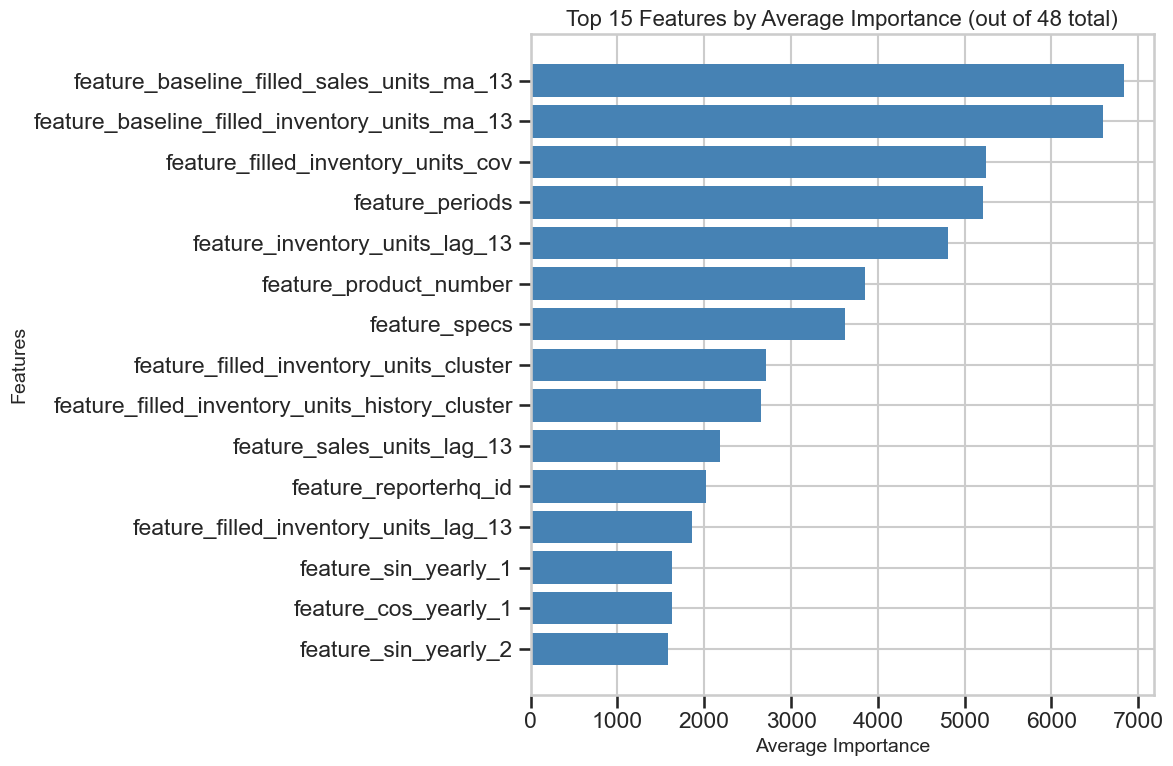

In [24]:
# Plot the average feature importance across all cutoffs
forecaster.plot_feature_importance()

## Run evaluator

In [25]:
# Params
actuals_col = 'inventory_units'
baseline_col = 'baseline_filled_inventory_units_ma_13'
preds_col = ['prediction']

# Initialize the Evaluator class
evaluator = Evaluator(df_with_preds, actuals_col, baseline_col, preds_col)

# Call the function
metric_table = evaluator.create_metric_table()

# Show
metric_table

,RMSE,MAE,MAPE,WMAPE,Custom Metric
baseline_filled_inventory_units_ma_13,56.66,42.32,181.71,59.31,61.78
prediction,55.14,41.20,176.52,57.76,57.85


## Lag metrics

In [26]:
# Params
metric_name = 'RMSE'
group_col = 'fcst_lag'
group_filter = range(1,14)

# Call the function
lag_metrics = evaluator.calculate_grouped_metric(metric_name, group_col, group_filter)

# Show
lag_metrics

fcst_lag,1,2,3,4,5,6,7,8,9,10,11,12,13
Baseline,48.896757,52.116324,54.577024,56.843273,58.728655,58.083774,58.896165,58.002683,60.303053,59.288602,58.946416,58.316552,60.681651
prediction,40.156688,46.486898,50.582903,54.144477,56.843010,57.224067,59.074741,59.237243,61.022740,60.410212,60.774021,60.232071,61.933045


# Plot predictions


In [27]:
# Get the max cutoff
max_cutoff = df_with_preds['cutoff'].max()

# Filter the DataFrame where cutoff is equal to the max cutoff
df_filtered = df_with_preds[df_with_preds['cutoff'] == max_cutoff]

# Show
df_filtered.head()

,reporterhq_id,product_number,prod_category,specs,display_size,segment,date,sales_units,inventory_units,filled_sales_units,filled_inventory_units,cutoff,sample,feature_reporterhq_id,feature_product_number,feature_prod_category,feature_specs,feature_display_size,feature_segment,feature_year,feature_quarter,feature_month,feature_week,feature_day,feature_dayofweek,feature_sin_yearly_1,feature_cos_yearly_1,feature_sin_yearly_2,feature_cos_yearly_2,feature_sin_yearly_3,feature_cos_yearly_3,feature_sin_quarterly_1,feature_cos_quarterly_1,feature_sin_quarterly_2,feature_cos_quarterly_2,feature_sin_monthly_1,feature_cos_monthly_1,feature_sin_monthly_2,feature_cos_monthly_2,feature_sin_weekly_1,feature_cos_weekly_1,feature_sin_weekly_2,feature_cos_weekly_2,feature_sin_weekly_3,feature_cos_weekly_3,feature_periods,feature_periods_expanding,feature_periods_sqrt,sales_units_ma_4,sales_units_ma_13,inventory_units_ma_4,inventory_units_ma_13,filled_sales_units_ma_4,filled_sales_units_ma_13,filled_inventory_units_ma_4,filled_inventory_units_ma_13,sales_units_min_4,sales_units_max_4,sales_units_min_13,sales_units_max_13,inventory_units_min_4,inventory_units_max_4,inventory_units_min_13,inventory_units_max_13,filled_sales_units_min_4,filled_sales_units_max_4,filled_sales_units_min_13,filled_sales_units_max_13,filled_inventory_units_min_4,filled_inventory_units_max_4,filled_inventory_units_min_13,filled_inventory_units_max_13,feature_sales_units_lag_13,feature_sales_units_lag_52,feature_inventory_units_lag_13,feature_inventory_units_lag_52,feature_filled_sales_units_lag_13,feature_filled_sales_units_lag_52,feature_filled_inventory_units_lag_13,feature_filled_inventory_units_lag_52,feature_filled_inventory_units_cov,feature_filled_inventory_units_cluster,feature_filled_inventory_units_history_cluster,train_weight,fcst_lag,feature_baseline_filled_sales_units_ma_13,feature_baseline_filled_inventory_units_ma_13,baseline_filled_sales_units_ma_13,baseline_filled_inventory_units_ma_13,training_group,guardrail,prediction
100556,12,10857,Doraemon,108304,15.6,Gaming,2021-01-30,0.0,52.0,0.0,52.0,2023-05-06,train,0,7,4,9,6,1,2021,1,1,4,30,5,0.493468,0.869764,0.858402,0.512978,0.999745,0.022576,0.880683,-0.473706,-0.834370,-0.551205,-0.201299,0.979530,-0.394356,0.918958,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,1.0,1.000000,1.000000,0.000000,0.000000,52.000000,52.000000,0.000000,0.000000,52.000000,52.000000,0.0,0.0,0.0,0.0,52.0,52.0,52.0,52.0,0.0,0.0,0.0,0.0,52.0,52.0,52.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.607849,11,12,0.008547,0,0.000000,52.000000,NaN,NaN,1,False,NaN
100557,12,10857,Doraemon,108304,15.6,Gaming,2021-02-06,8.0,48.0,8.0,48.0,2023-05-06,train,0,7,4,9,6,1,2021,1,2,5,6,5,0.594376,0.804187,0.955979,0.293434,0.943196,-0.332235,0.561034,-0.827793,-0.928839,0.370483,0.974928,0.222521,0.433884,-0.900969,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,2.0,2.143547,1.414214,4.000000,4.000000,50.000000,50.000000,4.000000,4.000000,50.000000,50.000000,0.0,8.0,0.0,8.0,48.0,52.0,48.0,52.0,0.0,8.0,0.0,8.0,48.0,52.0,48.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.607849,11,12,0.017094,0,4.000000,50.000000,NaN,NaN,1,False,NaN
100558,12,10857,Doraemon,108304,15.6,Gaming,2021-02-13,39.0,72.0,39.0,72.0,2023-05-06,train,0,7,4,9,6,1,2021,1,2,6,13,5,0.686676,0.726964,0.998377,0.056952,0.764891,-0.644159,0.113720,-0.993513,-0.225964,0.974136,0.222521,-0.974928,-0.433884,0.900969,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,3.0,3.348370,1.732051,15.666667,15.666667,57.333333,57.333333,15.666667,15.666667,57.333333,57.333333,0.0,39.0,0.0,39.0,48.0,72.0,48.0,72.0,0.0,39.0,0.0,39.0,48.0,72.0,48.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.607849,11,12,0.025641,0,15.666667,57.333333,NaN,NaN,1,False,NaN
100559,12,10857,Doraemon,108304,15.6,Gaming,2021-02-20,0.0,138.0,0.0,138.0,2023-05-06,train,0,7,4,9,6,1,2021,1,2,7,20,5,0.769031,0.639212,0.983147,-0.182817,0.487847,-0.872929,-0.359472,-0.933156,0.670887,0.741560,-0.974928,-0.222521,0.433884,-0

In [28]:
# Params
baseline_col = 'baseline_filled_inventory_units_ma_13'
target_col = 'inventory_units'
top_n_plots = 6

## Plot by Reporter

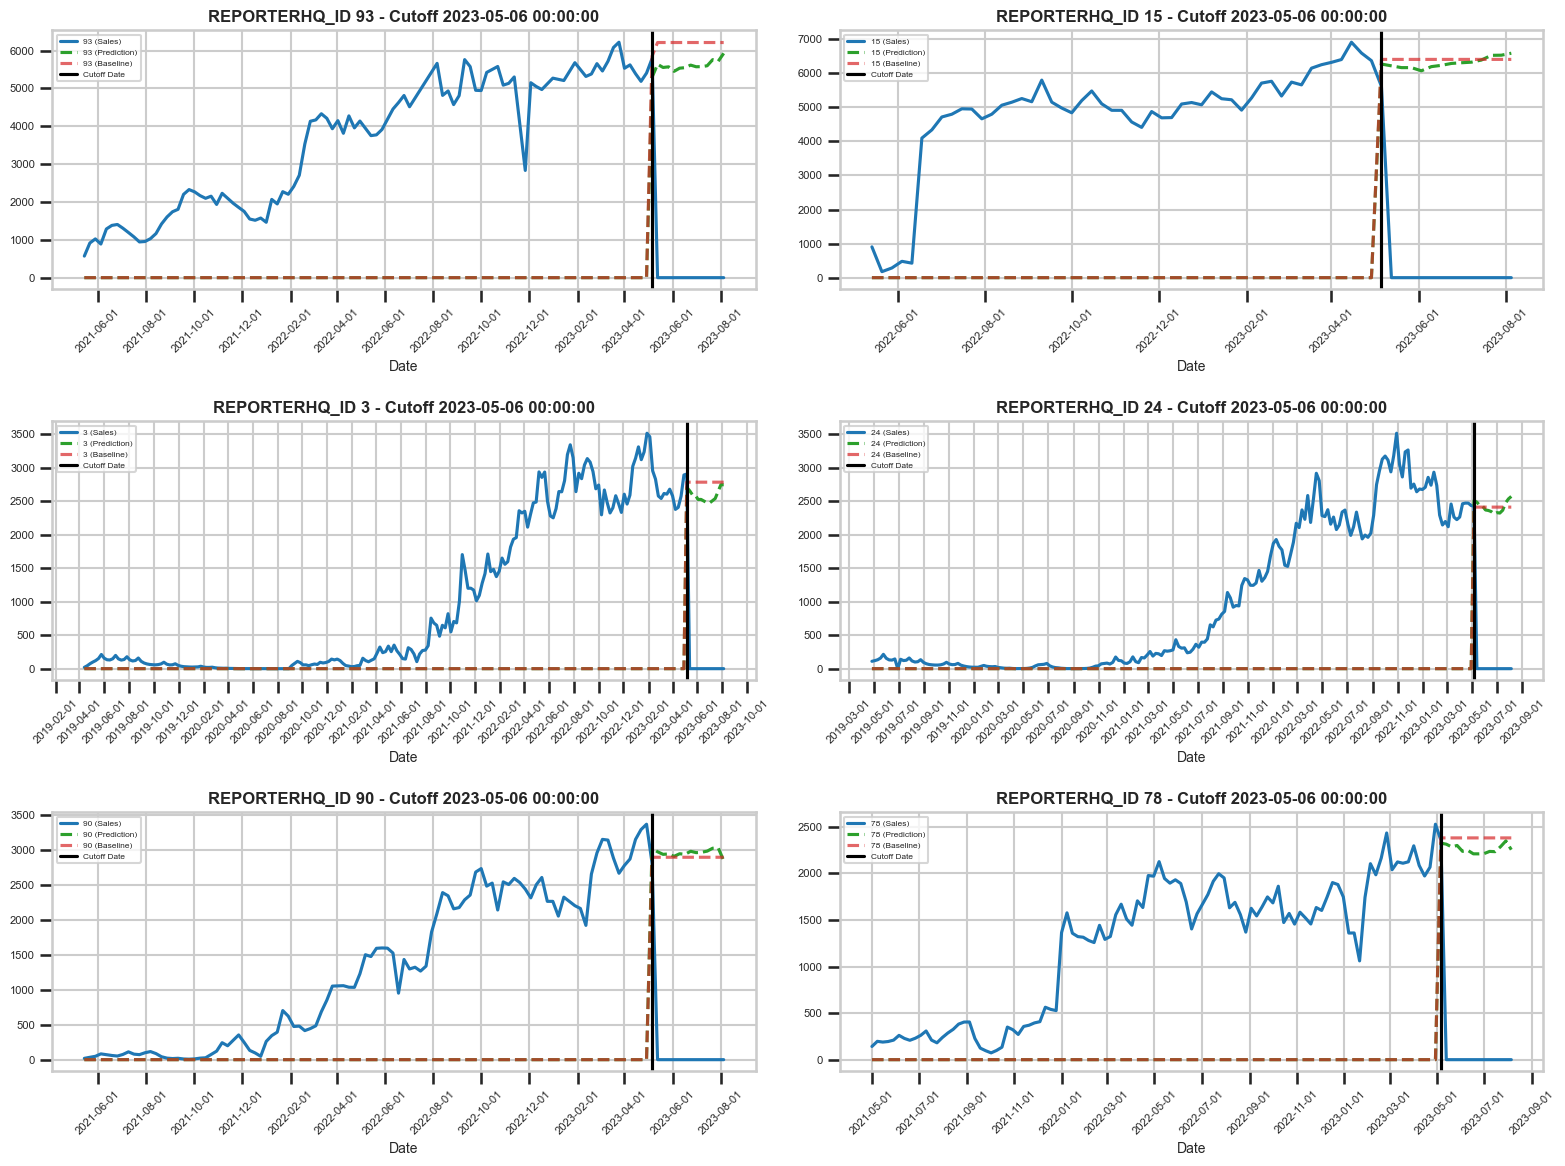

In [29]:
# Plot by client
process_and_plot(
    df_filtered,
    group_col='reporterhq_id',
    baseline_col=baseline_col,
    target_col=target_col,
    top_n=top_n_plots,
    title='Top Reporter Target vs Baseline vs Prediction'
)

## Plot by Product

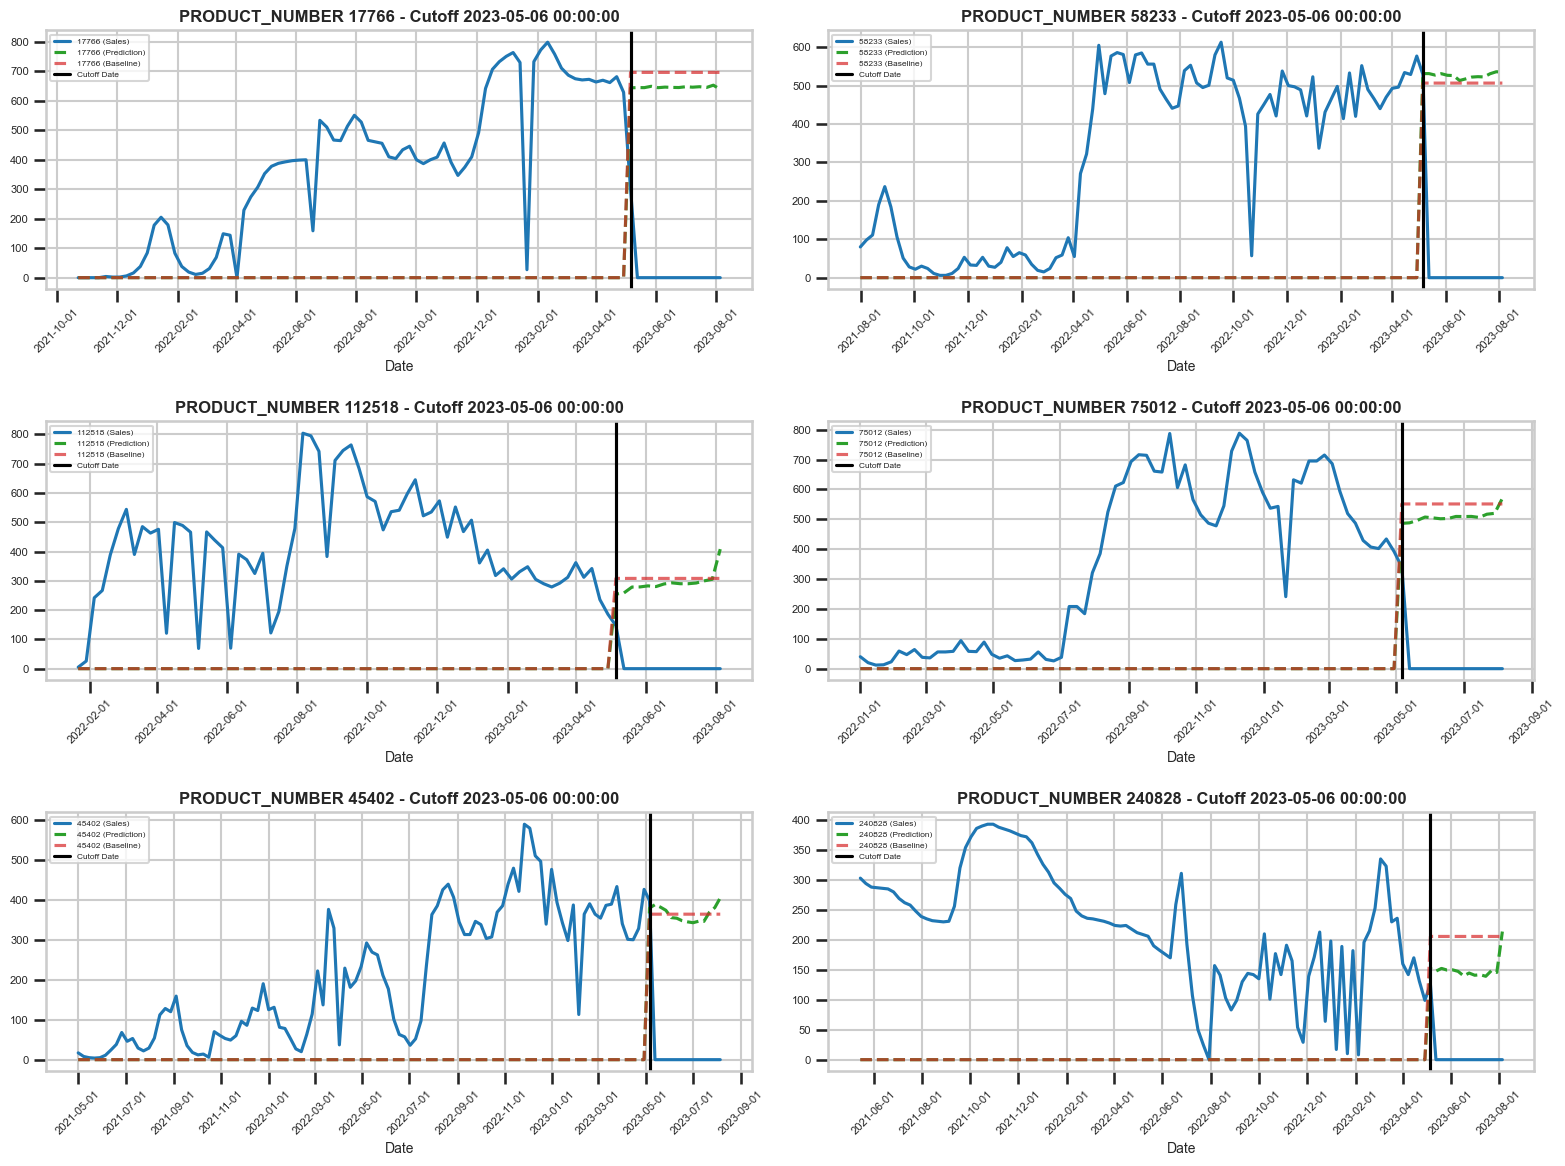

In [30]:
# Plot by product
process_and_plot(
    df_filtered,
    group_col='product_number',
    baseline_col=baseline_col,
    target_col=target_col,
    top_n=top_n_plots,
    title='Top Products Target vs Baseline vs Prediction'
)

# Save output

In [31]:
# Create the filename with the phase appended
file_name = f'Data/df_lightgbm_runner_preds.csv'

# Write the dataframe to the CSV file
df_with_preds.to_csv(file_name, index=False)

# Clean

In [32]:
# Garbage collection
gc.collect()

59915